#Author- MD Fakrul Islam
#Email- fakruldsebd@gmail.com

#Import all necessery libraries

In [0]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import json
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
from prettytable import PrettyTable

Using TensorFlow backend.


#Download the Dataset
#It was collected from
#https://zenodo.org/record/1188976/#.XpRg1HUzY5k
#Description
Audio-only files

Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):

Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440. 
Song file (Audio_Song_Actors_01-24.zip, 198 MB) contains 1012 files: 44 trials per actor x 23 actors = 1012.
Audio-Visual and Video-only files

Video files are provided as separate zip downloads for each actor (01-24, ~500 MB each), and are split into separate speech and song downloads:

Speech files (Video_Speech_Actor_01.zip to Video_Speech_Actor_24.zip) collectively contains 2880 files: 60 trials per actor x 2 modalities (AV, VO) x 24 actors = 2880.
Song files (Video_Song_Actor_01.zip to Video_Song_Actor_24.zip) collectively contains 2024 files: 44 trials per actor x 2 modalities (AV, VO) x 23 actors = 2024.
File Summary

In total, the RAVDESS collection includes 7356 files (2880+2024+1440+1012 files).

File naming convention

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

Filename identifiers 

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 02-01-06-01-02-01-12.mp4 

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

In [0]:
!curl -LO https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  5335k      0  0:00:38  0:00:38 --:--:-- 4716k


#Extract the Dataset
#Store the Dataset into
#/content/all_actors

In [0]:
# importing required modules 
from zipfile import ZipFile 

# specifying the zip file name 
file_name = "/content/Audio_Speech_Actors_01-24.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
	# printing all the contents of the zip file 
	zip.printdir() 

	# extracting all the files 
	print('Extracting all the files now...') 
	zip.extractall('/content/all_actors') 
	print('Done!') 

File Name                                             Modified             Size
Actor_01/                                      2018-03-22 15:54:06            0
Actor_01/03-01-01-01-01-01-01.wav              2018-03-22 15:54:06       375720
Actor_01/03-01-01-01-01-02-01.wav              2018-03-22 15:54:06       379106
Actor_01/03-01-01-01-02-01-01.wav              2018-03-22 15:54:06       372698
Actor_01/03-01-01-01-02-02-01.wav              2018-03-22 15:54:06       363108
Actor_01/03-01-02-01-01-01-01.wav              2018-03-22 15:54:06       399494
Actor_01/03-01-02-01-01-02-01.wav              2018-03-22 15:54:06       751848
Actor_01/03-01-02-01-02-01-01.wav              2018-03-22 15:54:06       396294
Actor_01/03-01-02-01-02-02-01.wav              2018-03-22 15:54:06       393086
Actor_01/03-01-02-02-01-01-01.wav              2018-03-22 15:54:06       415516
Actor_01/03-01-02-02-01-02-01.wav              2018-03-22 15:54:08       444344
Actor_01/03-01-02-02-02-01-01.wav       

In [0]:
#Confusion matrix plotting
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

print('#Confusion matrix plotting Done')

#Confusion matrix plotting Done


In [0]:
#Segmenting all 10 sentiments, confusion matrix
def all_sentiments(feeling_list,mfcc_array):
  labels=feeling_list
  opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
  
  df=pd.DataFrame(mfcc_array)
  x_train,y_train,x_test,y_test,lb=train_test_split(df,labels)
  
  unique=set(labels)
  op_len=len(unique)
  ip_len=len(x_train[0])
  #CNN
  
  modelcnn=model_CNN(ip_len,op_len)
  print(modelcnn.summary())
  modelcnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
  cnnhistory=modelcnn.fit(x_train, y_train, batch_size=16, epochs=700, validation_data=(x_test, y_test))
  
  plot_graph(cnnhistory)
  save_model(modelcnn)
  loaded_model=load_evaluate(modelcnn,x_train, y_train,x_test,y_test)
 
  #Predict emotions on test data
  preds = loaded_model.predict(x_test, 
                           batch_size=32, 
                           verbose=1)
  preds1=preds.argmax(axis=1)
  abc = preds1.astype(int).flatten()

  predictions = (lb.inverse_transform((abc)))

  preddf = pd.DataFrame({'predictedvalues': predictions})
  actual=y_test.argmax(axis=1)
  abc123 = actual.astype(int).flatten()
  actualvalues = (lb.inverse_transform((abc123)))

  actualdf = pd.DataFrame({'actualvalues': actualvalues})
  finaldf = actualdf.join(preddf)
  uniq=set(finaldf.iloc[:,0])
  
  #Save Actual Vs Predicted labels in predictions.csv
  
  finaldf.to_csv('Predictions.csv', index=False)
  actual = actualdf
  predicted = preddf
  
  #Plot confusion matrix
  
  results = confusion_matrix(actual, predicted) 
  
  plot_confusion_matrix(cm = results,
                      normalize    = False,
                      target_names = set(feeling_list),
                      title        = "Confusion Matrix")
  
  confusion_df=pd.DataFrame(results)
  confusion_df.columns=uniq
  confusion_df.index=uniq
  
  confusion_df_new=confusion_df.T
  
  #Check from observations ,if samples are getting misclassified based on genders or based on sentiments
  
  female_calm_total= confusion_df_new.female_calm.female_calm+confusion_df_new.female_calm.female_happy+confusion_df_new.female_calm.male_fearful+confusion_df_new.female_calm.female_angry+confusion_df_new.female_calm.male_calm+confusion_df_new.female_calm.male_sad+confusion_df_new.female_calm.female_sad+confusion_df_new.female_calm.male_happy+confusion_df_new.female_calm.female_fearful+confusion_df_new.female_calm.male_angry
  female_happy_total= confusion_df_new.female_happy.female_calm+confusion_df_new.female_happy.female_happy+confusion_df_new.female_happy.male_fearful+confusion_df_new.female_happy.female_angry+confusion_df_new.female_happy.male_calm+confusion_df_new.female_happy.male_sad+confusion_df_new.female_happy.female_sad+confusion_df_new.female_happy.male_happy+confusion_df_new.female_happy.female_fearful+confusion_df_new.female_happy.male_angry

  male_fearful_total= confusion_df_new.male_fearful.female_calm+confusion_df_new.male_fearful.female_happy+confusion_df_new.male_fearful.male_fearful+confusion_df_new.male_fearful.female_angry+confusion_df_new.male_fearful.male_calm+confusion_df_new.male_fearful.male_sad+confusion_df_new.male_fearful.female_sad+confusion_df_new.male_fearful.male_happy+confusion_df_new.male_fearful.female_fearful+confusion_df_new.male_fearful.male_angry
  female_angry_total= confusion_df_new.female_angry.female_calm+confusion_df_new.female_angry.female_happy+confusion_df_new.female_angry.male_fearful+confusion_df_new.female_angry.female_angry+confusion_df_new.female_angry.male_calm+confusion_df_new.female_angry.male_sad+confusion_df_new.female_angry.female_sad+confusion_df_new.female_angry.male_happy+confusion_df_new.female_angry.female_fearful+confusion_df_new.female_angry.male_angry

  male_calm_total= confusion_df_new.male_calm.female_calm+confusion_df_new.male_calm.female_happy+confusion_df_new.male_calm.male_fearful+confusion_df_new.male_calm.female_angry+confusion_df_new.male_calm.male_calm+confusion_df_new.male_calm.male_sad+confusion_df_new.male_calm.female_sad+confusion_df_new.male_calm.male_happy+confusion_df_new.male_calm.female_fearful+confusion_df_new.male_calm.male_angry
  male_sad_total= confusion_df_new.male_sad.female_calm+confusion_df_new.male_sad.female_happy+confusion_df_new.male_sad.male_fearful+confusion_df_new.male_sad.female_angry+confusion_df_new.male_sad.male_calm+confusion_df_new.male_sad.male_sad+confusion_df_new.male_sad.female_sad+confusion_df_new.male_sad.male_happy+confusion_df_new.male_sad.female_fearful+confusion_df_new.male_sad.male_angry

  female_sad_total= confusion_df_new.female_sad.female_calm+confusion_df_new.female_sad.female_happy+confusion_df_new.female_sad.male_fearful+confusion_df_new.female_sad.female_angry+confusion_df_new.female_sad.male_calm+confusion_df_new.female_sad.male_sad+confusion_df_new.female_sad.female_sad+confusion_df_new.female_sad.male_happy+confusion_df_new.female_sad.female_fearful+confusion_df_new.female_sad.male_angry
  male_happy_total= confusion_df_new.male_happy.female_calm+confusion_df_new.male_happy.female_happy+confusion_df_new.male_happy.male_fearful+confusion_df_new.male_happy.female_angry+confusion_df_new.male_happy.male_calm+confusion_df_new.male_happy.male_sad+confusion_df_new.male_happy.female_sad+confusion_df_new.male_happy.male_happy+confusion_df_new.male_happy.female_fearful+confusion_df_new.male_happy.male_angry

  female_fearful_total= confusion_df_new.female_fearful.female_calm+confusion_df_new.female_fearful.female_happy+confusion_df_new.female_fearful.male_fearful+confusion_df_new.female_fearful.female_angry+confusion_df_new.female_fearful.male_calm+confusion_df_new.female_fearful.male_sad+confusion_df_new.female_fearful.female_sad+confusion_df_new.female_fearful.male_happy+confusion_df_new.female_fearful.female_fearful+confusion_df_new.female_fearful.male_angry
  male_angry_total= confusion_df_new.male_angry.female_calm+confusion_df_new.male_angry.female_happy+confusion_df_new.male_angry.male_fearful+confusion_df_new.male_angry.female_angry+confusion_df_new.male_angry.male_calm+confusion_df_new.male_angry.male_sad+confusion_df_new.male_angry.female_sad+confusion_df_new.male_angry.male_happy+confusion_df_new.male_angry.female_fearful+confusion_df_new.male_angry.male_angry
  
  #Actual Vs predicted for female sad and male sad
  
  x = PrettyTable()

  x.field_names = ["Type","Female sad", "Male sad", "Others"]

  x.add_row(["Female sad", confusion_df_new.female_sad.female_sad, confusion_df_new.female_sad.male_sad, female_sad_total-(confusion_df_new.female_sad.female_sad+confusion_df_new.female_sad.male_sad)])
  x.add_row(["Male sad", confusion_df_new.male_sad.female_sad, confusion_df_new.male_sad.male_sad, male_sad_total-(confusion_df_new.male_sad.female_sad+confusion_df_new.male_sad.male_sad)])

  print("Actual Vs Predicted")
  print(x)  
  
  #Actual Vs predicted for Female happy and Male happy
  
  x = PrettyTable()

  x.field_names = ["Type","Female happy", "Male happy", "Others"]

  x.add_row(["Female happy", confusion_df_new.female_happy.female_happy, confusion_df_new.female_happy.male_happy, female_happy_total-(confusion_df_new.female_happy.female_happy+confusion_df_new.female_happy.male_happy)])
  x.add_row(["Male happy", confusion_df_new.male_happy.female_happy, confusion_df_new.male_happy.male_happy, male_happy_total-(confusion_df_new.male_happy.male_happy+confusion_df_new.male_happy.female_happy)])

  print("Actual Vs Predicted")
  print(x)
  
  #Actual Vs predicted for Female angry and Male angry
  
  x = PrettyTable()

  x.field_names = ["Type","Female angry", "Male angry", "Others"]

  x.add_row(["Female angry", confusion_df_new.female_angry.female_angry, confusion_df_new.female_angry.male_angry, female_angry_total-(confusion_df_new.female_angry.female_angry+confusion_df_new.female_angry.male_angry)])
  x.add_row(["Male angry", confusion_df_new.male_angry.female_angry, confusion_df_new.male_angry.male_angry, male_angry_total-(confusion_df_new.male_angry.male_angry+confusion_df_new.male_angry.female_angry)])

  print("Actual Vs Predicted")
  print(x)
  
  #Actual Vs predicted for Female calm and Male calm
     
  x = PrettyTable()

  x.field_names = ["Type","Female calm", "Male calm", "Others"]

  x.add_row(["Female calm", confusion_df_new.female_calm.female_calm, confusion_df_new.female_calm.male_calm, female_calm_total-(confusion_df_new.female_calm.female_calm+confusion_df_new.female_calm.male_calm)])
  x.add_row(["Male calm", confusion_df_new.male_calm.female_calm, confusion_df_new.male_calm.male_calm, male_calm_total-(confusion_df_new.male_calm.male_calm+confusion_df_new.male_calm.female_calm)])

  
  print("Actual Vs Predicted")
  print(x)
  
  #Actual Vs predicted for Female fearful and Male fearful
     
  x = PrettyTable()

  x.field_names = ["Type","Female fearful", "Male fearful", "Others"]

  x.add_row(["Female fearful", confusion_df_new.female_fearful.female_fearful, confusion_df_new.female_fearful.male_fearful, female_fearful_total-(confusion_df_new.female_fearful.female_fearful+confusion_df_new.female_fearful.male_fearful)])
  x.add_row(["Male fearful", confusion_df_new.male_fearful.female_fearful, confusion_df_new.male_fearful.male_fearful, male_fearful_total-(confusion_df_new.male_fearful.male_fearful+confusion_df_new.male_fearful.female_fearful)])

  
  print("Actual Vs Predicted")
  print(x)

print('#Segmenting all 10 sentiments, confusion matrix')

#Segmenting all 10 sentiments, confusion matrix


In [0]:
#Segmenting Four classes: female calm, male calm, female angry, male angry 
def four_classes(feeling_list,mfcclist_mean):
  labels=[]
  list_features=[]
  opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
  for i in range(len(feeling_list)):
    if(feeling_list[i]=='female_calm' or feeling_list[i]=='female_angry' or 
       feeling_list[i]=='male_calm' or feeling_list[i]=='male_angry'):
      labels.append(feeling_list[i])
      list_features.append(mfcclist_mean[i])
    
  df=pd.DataFrame(list_features)
  x_train,y_train,x_test,y_test,lb=train_test_split(df,labels)
 
  unique=set(labels)
  op_len=len(unique)
  ip_len=len(x_train[0])
  #CNN
  
  modelcnn=model_CNN(ip_len,op_len)
  print(modelcnn.summary())
  modelcnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
  cnnhistory=modelcnn.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test, y_test))
  
  plot_graph(cnnhistory)
  save_model(modelcnn)
  load_evaluate(modelcnn,x_train, y_train,x_test,y_test)

print('#Segmenting Four classes: female calm, male calm, female angry, male angry ')

#Segmenting Four classes: female calm, male calm, female angry, male angry 


In [0]:
#Splits the samples in the dataset into train set and test set
def train_test_split(df,feeling_list):
  labels = pd.DataFrame(feeling_list)
  newdf = pd.concat([df,labels], axis=1)
  
  training_samples=round(df.shape[0]*0.8)
  rnewdf=newdf
  rnewdf = shuffle(rnewdf)
  rnewdf.shape
  rnewdf=rnewdf.fillna(0)
  #newdf1 = np.random.rand(len(rnewdf)) < 0.7
  train = rnewdf[0:training_samples]
  test = rnewdf[training_samples:]
  
  trainfeatures = train.iloc[:, :-1]
  trainlabel = train.iloc[:, -1:]
  testfeatures = test.iloc[:, :-1]
  testlabel = test.iloc[:, -1:]
  X_train = np.array(trainfeatures)
  y_train = np.array(trainlabel)
  X_test = np.array(testfeatures)
  y_test = np.array(testlabel)

  lb = LabelEncoder()
  
  #Perform One hot encoding 
  
  y_train = np_utils.to_categorical(lb.fit_transform(y_train))
  y_test = np_utils.to_categorical(lb.fit_transform(y_test))
  x_traincnn =np.expand_dims(X_train, axis=2)
  x_testcnn= np.expand_dims(X_test, axis=2)
  
  return x_traincnn,y_train,x_testcnn,y_test,lb

#Sentiment analysis : positive and negative emotions
#Positive emotion bucket : calm,happy
#Negative emotion bucket : sad,fearful,angry

print('#Splits the samples in the dataset into train set and test set')

#Splits the samples in the dataset into train set and test set


In [0]:
def segment_pos_neg_emotions(feeling_list,mfcclist_mean):
  labels=[]
  opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
  for i in range(len(feeling_list)):
    if(feeling_list[i]=='female_sad' or feeling_list[i]=='female_angry' or 
       feeling_list[i]=='female_fearful' or feeling_list[i]=='male_sad' or 
       feeling_list[i]=='male_angry' or feeling_list[i]=='male_fearful'):
      labels.append('Negative')
    else:
      labels.append('Positive')
  df=pd.DataFrame(mfcclist_mean)
  x_train,y_train,x_test,y_test,lb=train_test_split(df,labels)
  
  unique=set(labels)
  op_len=len(unique)
  ip_len=len(x_train[0])
  
  #CNN
  
  modelcnn=model_CNN(ip_len,op_len)
  print(modelcnn.summary())
  modelcnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
  cnnhistory=modelcnn.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test, y_test))
  
  plot_graph(cnnhistory)
  save_model(modelcnn)
  load_evaluate(modelcnn,x_train, y_train,x_test,y_test)

print('segment_pos_neg_emotions')

segment_pos_neg_emotions


In [0]:
#CNN model initializing
def model_CNN(inputlen,outputlen):
  
  model = Sequential()

  model.add(Conv1D(256, 5,padding='same',
                   input_shape=(inputlen,1)))
  model.add(Activation('relu'))
  model.add(Conv1D(128, 5,padding='same'))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',))
  model.add(Activation('relu'))
 
  model.add(Conv1D(128, 5,padding='same',))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(outputlen))
  model.add(Activation('softmax'))
 
  
  return model

print('#CNN model initializing')

#CNN model initializing


In [0]:
def save_model(model):
  model_name = 'Emotion_Voice_Detection_Model.h5'
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

print('Save Model')

Save Model


In [0]:
def plot_graph(cnnhistory):
  plt.plot(cnnhistory.history['loss'])
  plt.plot(cnnhistory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

print('plot graph')

plot graph


In [0]:
#Evaluate the model 
def load_evaluate(model,x_traincnn, y_train,x_testcnn,y_test):
  opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
      json_file.write(model_json)
  
  json_file = open('model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  
  # load weights into new model
  loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
  print("Loaded model from disk")

  # evaluate loaded model on test data and train data
  loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  print("Train Accuracy :")
  score = loaded_model.evaluate(x_traincnn,y_train, verbose=0)
  print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
  print("Test Accuracy :")
  score = loaded_model.evaluate(x_testcnn,y_test, verbose=0)
  print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
  return loaded_model

print('#Evaluate the model ')

#Evaluate the model 


#Get all files name from /content/all_actors

In [0]:
from os import listdir

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles
  
print('Get all files name from /content/all_actors')

Get all files name from /content/all_actors


#Show all wav files with path name.

In [0]:
dirName = '/content/all_actors';

# Get the list of all files in directory tree at given path
listOfFiles = getListOfFiles(dirName)
print(listOfFiles)

['/content/all_actors/Actor_04/03-01-03-01-02-02-04.wav', '/content/all_actors/Actor_04/03-01-06-02-01-01-04.wav', '/content/all_actors/Actor_04/03-01-04-01-02-02-04.wav', '/content/all_actors/Actor_04/03-01-05-01-01-01-04.wav', '/content/all_actors/Actor_04/03-01-04-01-01-01-04.wav', '/content/all_actors/Actor_04/03-01-06-02-02-01-04.wav', '/content/all_actors/Actor_04/03-01-02-01-02-02-04.wav', '/content/all_actors/Actor_04/03-01-06-01-01-02-04.wav', '/content/all_actors/Actor_04/03-01-08-01-01-01-04.wav', '/content/all_actors/Actor_04/03-01-07-02-01-02-04.wav', '/content/all_actors/Actor_04/03-01-02-02-02-01-04.wav', '/content/all_actors/Actor_04/03-01-03-02-02-01-04.wav', '/content/all_actors/Actor_04/03-01-06-02-02-02-04.wav', '/content/all_actors/Actor_04/03-01-01-01-01-02-04.wav', '/content/all_actors/Actor_04/03-01-05-02-01-01-04.wav', '/content/all_actors/Actor_04/03-01-04-01-02-01-04.wav', '/content/all_actors/Actor_04/03-01-06-01-02-01-04.wav', '/content/all_actors/Actor_04/

#Show all wav files

In [0]:
mylist = []

for item in  listOfFiles:
  head, tail = os.path.split(item)
  mylist.append(tail)

print(mylist)

['03-01-03-01-02-02-04.wav', '03-01-06-02-01-01-04.wav', '03-01-04-01-02-02-04.wav', '03-01-05-01-01-01-04.wav', '03-01-04-01-01-01-04.wav', '03-01-06-02-02-01-04.wav', '03-01-02-01-02-02-04.wav', '03-01-06-01-01-02-04.wav', '03-01-08-01-01-01-04.wav', '03-01-07-02-01-02-04.wav', '03-01-02-02-02-01-04.wav', '03-01-03-02-02-01-04.wav', '03-01-06-02-02-02-04.wav', '03-01-01-01-01-02-04.wav', '03-01-05-02-01-01-04.wav', '03-01-04-01-02-01-04.wav', '03-01-06-01-02-01-04.wav', '03-01-08-02-02-01-04.wav', '03-01-03-02-01-01-04.wav', '03-01-03-01-01-01-04.wav', '03-01-07-02-02-02-04.wav', '03-01-07-01-02-01-04.wav', '03-01-05-02-02-02-04.wav', '03-01-04-02-01-01-04.wav', '03-01-03-02-01-02-04.wav', '03-01-08-02-01-02-04.wav', '03-01-04-02-01-02-04.wav', '03-01-06-02-01-02-04.wav', '03-01-03-01-02-01-04.wav', '03-01-02-02-01-02-04.wav', '03-01-05-01-02-01-04.wav', '03-01-05-01-02-02-04.wav', '03-01-07-02-01-01-04.wav', '03-01-04-02-02-01-04.wav', '03-01-05-02-02-01-04.wav', '03-01-08-01-02-01-

#Populate the sentiment vector

In [0]:
feeling_list=[]

# Labelling ten classes
i = 0
for item in mylist:
    i = i+1
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')        
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')        
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')        
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')        
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')        
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')        
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')        
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')        
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')        
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')        
    elif item[:1]=='a':
        feeling_list.append('male_angry')        
    elif item[:1]=='f':
        feeling_list.append('male_fearful')        
    elif item[:1]=='h':
        feeling_list.append('male_happy')            
    elif item[:2]=='sa':
        feeling_list.append('male_sad')


print(feeling_list)

['female_happy', 'female_fearful', 'female_sad', 'female_angry', 'female_sad', 'female_fearful', 'female_calm', 'female_fearful', 'female_calm', 'female_happy', 'female_fearful', 'female_angry', 'female_sad', 'female_fearful', 'female_happy', 'female_happy', 'female_angry', 'female_sad', 'female_happy', 'female_sad', 'female_fearful', 'female_happy', 'female_calm', 'female_angry', 'female_angry', 'female_sad', 'female_angry', 'female_calm', 'female_calm', 'female_happy', 'female_fearful', 'female_sad', 'female_happy', 'female_angry', 'female_angry', 'female_calm', 'female_calm', 'female_fearful', 'female_calm', 'female_sad', 'female_happy', 'female_sad', 'female_sad', 'female_calm', 'female_angry', 'female_sad', 'female_happy', 'female_fearful', 'female_sad', 'female_fearful', 'female_calm', 'female_fearful', 'female_happy', 'female_calm', 'female_angry', 'female_sad', 'female_angry', 'female_calm', 'female_happy', 'female_sad', 'female_angry', 'female_fearful', 'female_happy', 'female

In [0]:
#setting number of mfcc coefficient per frame to 13.
n_mfcc=13

#Extracting the MFCC features for all ten classes
'''MFCC as feature : For audio analysis, the shape of the vocal tract manifests itself in the envelope of the short time power spectrum, 
and the feature which accurately represent this envelope is MFCC.
Mel Frequency Cepstral Coefficents (MFCCs) is the feature widely used in automatic speech and speaker recognition.
sampling rate=44.1KHz is and duration of 2.5 sec of audio has been considered while loading package through librosa'''

#In our analysis 13 MFCC across every frame of sample is used 
mfcclist=[]
for index,y in enumerate(listOfFiles):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':

        X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_mfcc)
        mfcclist.append(mfccs)

In [0]:
print(mfcclist)
#Convert 2D array of mfccs to 1D array
df_reshape=[]
for data in mfcclist:
 
  d = np.reshape(data,-1).tolist()
  df_reshape.append(d)

[array([[-7.80990392e+02, -7.80990392e+02, -7.80990392e+02, ...,
        -7.77540063e+02, -7.77864370e+02, -7.78602029e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.67485072e+00,  4.32453665e+00,  3.25338790e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.11034785e+00,  4.04664349e+00,  2.90547831e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.27935902e-01,  5.63628402e-01,  9.10619324e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.12991867e-01,  4.71203001e-01,  1.08617422e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.81634923e-01,  4.31567537e-01,  1.20723037e+00]]), array([[-6.09233360e+02, -6.09233360e+02, -6.09233360e+02, ...,
        -5.89038802e+02, -5.96527325e+02, -6.02405746e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01624344e+01,  1.45496745e+01,  8.36238771

In [0]:
#Exclude MFCC having less dimension it supposed to be

list_mfcc=[]
for data, i in zip(df_reshape,range(len(df_reshape))):
  if len(data) == len(df_reshape[0]):
    
    list_mfcc.append(data)
  else:
    index_exclude=i
len(list_mfcc[0])
mfcc_array = np.array(list_mfcc)
mfcc_array.shape

(959, 2808)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2808, 256)         1536      
_________________________________________________________________
activation_1 (Activation)    (None, 2808, 256)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2808, 128)         163968    
_________________________________________________________________
activation_2 (Activation)    (None, 2808, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2808, 128)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 351, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 351, 128)         

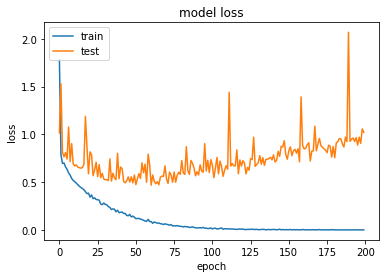

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 
Loaded model from disk
Train Accuracy :
accuracy: 100.00%
Test Accuracy :
accuracy: 81.77%


In [0]:
#Exclude label corresponding to excluded MFCC index
feeling_list.pop(index_exclude)

#Analysing the positive and negative emotions from the dataset
'''Bucket sentiments in terms of their positive and negative emotions.
Positive emotions such as calm,happy and negative emotions such  as angry, fearful,sad'''

segment_pos_neg_emotions(feeling_list,mfcc_array)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2808, 256)         1536      
_________________________________________________________________
activation_6 (Activation)    (None, 2808, 256)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2808, 128)         163968    
_________________________________________________________________
activation_7 (Activation)    (None, 2808, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2808, 128)         0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 351, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 351, 128)         

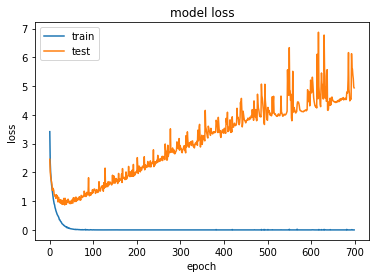

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 
Loaded model from disk
Train Accuracy :
accuracy: 100.00%
Test Accuracy :
accuracy: 69.27%
192/192 [==============================] - 0s 404us/step


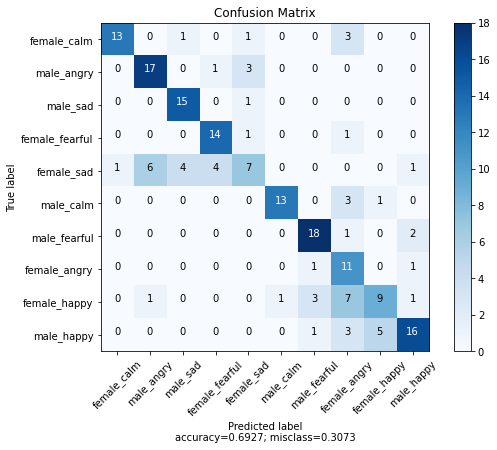

Actual Vs Predicted
+------------+------------+----------+--------+
|    Type    | Female sad | Male sad | Others |
+------------+------------+----------+--------+
| Female sad |     7      |    4     |   12   |
|  Male sad  |     1      |    15    |   0    |
+------------+------------+----------+--------+
Actual Vs Predicted
+--------------+--------------+------------+--------+
|     Type     | Female happy | Male happy | Others |
+--------------+--------------+------------+--------+
| Female happy |      9       |     1      |   12   |
|  Male happy  |      5       |     16     |   4    |
+--------------+--------------+------------+--------+
Actual Vs Predicted
+--------------+--------------+------------+--------+
|     Type     | Female angry | Male angry | Others |
+--------------+--------------+------------+--------+
| Female angry |      11      |     0      |   2    |
|  Male angry  |      0       |     17     |   4    |
+--------------+--------------+------------+--------+
Actu

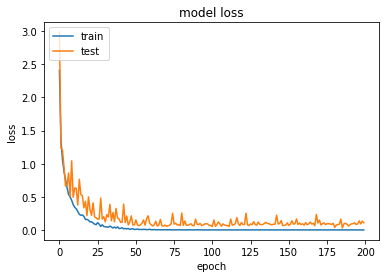

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 
Loaded model from disk
Train Accuracy :
accuracy: 100.00%
Test Accuracy :
accuracy: 98.70%


In [0]:
#Segment 5 sentiments across 2 genders (10 classes)
all_sentiments(feeling_list,mfcc_array)

'''EDA.py shows centroids of each class ,intercentroid distances between class sentiments along with their intracluster distance with its centroid.
From the observation of calculated intercentroid distances, it is clear that distance between the centroid of male_calm & centroid of male_angry is high similar is the case for female_calm and female_angry.
Hence, we chose to classify between four labels i.e. male_calm,male_angry,female_calm,female_angry'''

four_classes(feeling_list,mfcc_array)